In [7]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pip install pydub

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
IPython.display.Audio("audio_examples/example_train.wav")
x = graph_spectrogram("audio_examples/example_train.wav")

In [8]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
721 

activate[1] len: different `activate` clips can have different lengths
731 



In [19]:
%%html
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
#### Dividing into time-intervals
Note that we may divide a 10 second interval of time with different units (steps).
* Raw audio divides 10 seconds into 441,000 units.
* A spectrogram divides 10 seconds into 5,511 units.
    * $T_x = 5511$
* You will use a Python module `pydub` to synthesize audio, and it divides 10 seconds into 10,000 units.
* The output of our model will divide 10 seconds into 1,375 units.
    * $T_y = 1375$
    * For each of the 1375 time steps, the model predicts whether someone recently finished saying the trigger word "activate." 
* All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). 
* We have chosen values that are within the standard range used for speech systems. = 1375 # The number of time steps in the output of our model

In [9]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [10]:
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start<=previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [11]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [12]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [13]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2915, 3635)


In [14]:
# Expected audio
IPython.display.Audio("audio_examples/insert_reference.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [20]:
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

sanity checks: 0.0 1.0 0.0


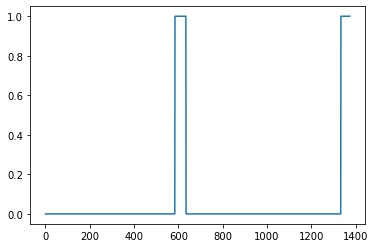

In [21]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [23]:
# GRADED FUNCTION: create_training_example

def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as an empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.


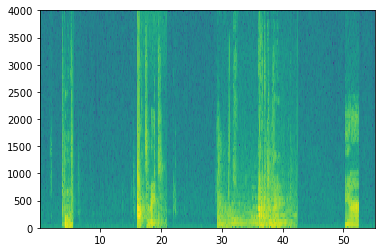

In [24]:
x, y = create_training_example(backgrounds[0], activates, negatives)

In [25]:
IPython.display.Audio("train.wav")